In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import math

import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format='retina'
%matplotlib inline

# Введение

Интернет_магазин "Стримчик" занимается реализацией компьютерных игр по всему миру. Ассортимент и разнообразие реализуемых игр многочисленно, от стратегий и пазлов до экшенов и спорт-игр. Также магазин реализует компьютерные игры на различных платформах, от PC до PS и Xbox. Одной из основных задач магазина является организация успешных рекламных компаний для продвижения продуктов.

В этом исследовании мы определим закономерности, определяющие успешность компьютерных игр. Эти данные необходимы для корректного определения потенциально успешных продуктов и таргетирования конкретным пользователям.

Также в ходе исследования мы составим примерный портрет пользователей из различных регионов.

И проверим две гипотезы: 

   - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;   
   - Средние пользовательские рейтинги жанров Action и Sports разные.
   
Для проведения исследования у нас в распоряжении имеется база данных о количестве проданных игр в различных регионах за период с 1980 по текущий год.

## Содержание

1. Обзор данных
2. Предобработка данных
3. Исследовательский анализ данных

   3.1. Оценка продаж по годам
   
   3.2. Оценка продаж по платформам
   
   3.3. Оценка влияния на продажи оценок критиков и пользователей
   
   3.4. Оценка продаж игр в различных жанрах
   
4. Составление портрета пользователя каждого региона

   4.1. Предпочтения пользователей среди игровых платформ
   
   4.2. предпочтения пользователей среди игровых жанров
   
   4.3. Предпочтения пользователей в зависимости от рейтинга `ESRB`
   
   4.4. Общий портрет пользователей из различных регинов
   
5. Проверка гипотез

   5.1. Гипотеза и равенстве средних пользовательских оценок платформ `PC` и `XOne`
   
   5.2. Гипотеза о равенстве средних пользовательских оценок игр жанров `Action` и `Sports`
   
6. Общий вывод

# 1. Обзор данных

Приступая к исследованию откроем полученную базу данных `games.csv` и посмотрим на общую информацию о датафрейме.

In [2]:
try:
    games = pd.read_csv('games.csv')
except:
    games = pd.read_csv('/datasets/games.csv')
    
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Мы видим, что у нас имеется датафрейм состоящий из 11 столбцов и 16715 строк. В нем представленны различные типы данных, а также мы можем сказать о наличии пропусков в данных.

Теперь перейдем к предобработке данных.

# 2. Предобработка данных

Приступая к предобработке данных, мы сразу заметили, что наименования столбцов в таблице представленны в плохочитаемом виде. Приведем названия к нижнему регистру.

In [4]:
games.columns = games.columns.str.lower()
games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Ранее, при первичном обзоре данных, мы выявили совсем небольшие (в единицы и десятки) пропуски в определенных колонках в датафрейме. Удалим эти пропуски из колонок `year_of_release`, `name` и `genre`.

In [5]:
games = games.dropna(subset=['year_of_release', 'name', 'genre']).reset_index()
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 12 columns):
index              16444 non-null int64
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null float64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null float64
user_score         9839 non-null object
rating             9768 non-null object
dtypes: float64(6), int64(1), object(5)
memory usage: 1.5+ MB


Далее, в колонке `year_of_release` указана дата выпуска игры. Заменим формат данных на `datetime`.

In [6]:
games['year_of_release'] = games['year_of_release'].astype(int)
games['year_of_release'] = games['year_of_release'].astype(str)

In [7]:
games['year_of_release'] = pd.to_datetime(games['year_of_release'])

В столбце `user_score` имеются значения `tbd` - `to be determined` ("будет определенно"). Это значения пользовательской оценки, которые из-за небольшого количества оценок не могут быть статистически определнны. Имеет смысл заменить эти значения на `nan`.

In [8]:
games.loc[games['user_score'] == 'tbd', 'user_score'] = float('nan')
games['user_score'] = games['user_score'].astype(float)

Посмотрим еще раз на общую информацию о наших данных.

In [9]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 12 columns):
index              16444 non-null int64
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null datetime64[ns]
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null float64
user_score         7463 non-null float64
rating             9768 non-null object
dtypes: datetime64[ns](1), float64(6), int64(1), object(4)
memory usage: 1.5+ MB


Форматы данных приведены к нужным значениям, мизерные пропуски удаленны.

Можно приступать к проверке датафрейма на дубликаты и пропуски.

In [10]:
games.head()

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,0,Wii Sports,Wii,2006-01-01,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,1,Super Mario Bros.,NES,1985-01-01,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,2,Mario Kart Wii,Wii,2008-01-01,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,3,Wii Sports Resort,Wii,2009-01-01,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,4,Pokemon Red/Pokemon Blue,GB,1996-01-01,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Проверим наш датафрейм на дубликаты.

In [11]:
games.duplicated().sum()

0

Дубликаты отсутствуют.

Теперь проверим на пропуски.

In [12]:
games.isna().sum()

index                 0
name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating             6676
dtype: int64

В наших данных имеется большое количество пропусков в колонках с оценками критиков и пользователей и рейтингом.

Это может быть вызванно отсутствием таких данных в конкретный период времени. Проверим наше предположение.

In [13]:
games_grp = (games.groupby('year_of_release')
             .agg({'critic_score':'count', 'user_score':'count', 'rating':'count'})
            )
games_grp

,critic_score,user_score,rating
year_of_release,,,
1980-01-01,0,0,0
1981-01-01,0,0,0
1982-01-01,0,0,0
1983-01-01,0,0,0
1984-01-01,0,0,0
1985-01-01,1,1,1
1986-01-01,0,0,0
1987-01-01,0,0,0
1988-01-01,1,1,1


Из полученной таблицы мы можем подтвердить наше раннее предположение и заключить, что до 2000 года не существовало либо не проводилось оценок игр, а также рейтинга.

Изабавляться от пропусков в этих данных нецелесообразно, так как мы теряем большое количество данных. Заменять их на "0" тоже не имеет смысла, в этом случае мы можем значительно исказить средние значения и результаты исследования.

Проверим данные на неочевидные дубликаты.

In [14]:
games['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

В колонке с наименованиями платформ вске в порядке.

In [15]:
games['genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

С игровыми жанрами тоже все "ОК".

In [16]:
games['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Рейтинг `ESRB` тоже соответствует действительности.

Посмотрим наш датафрейм на аномальные значения и выбросы в значениях продаж по регионам.

Построим диаграммы рассеяния.

C:\Users\Vladimir\anaconda3\envs\praktikum_env_win_new\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Vladimir\anaconda3\envs\praktikum_env_win_new\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Vladimir\anaconda3\envs\praktikum_env_win_new\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will r

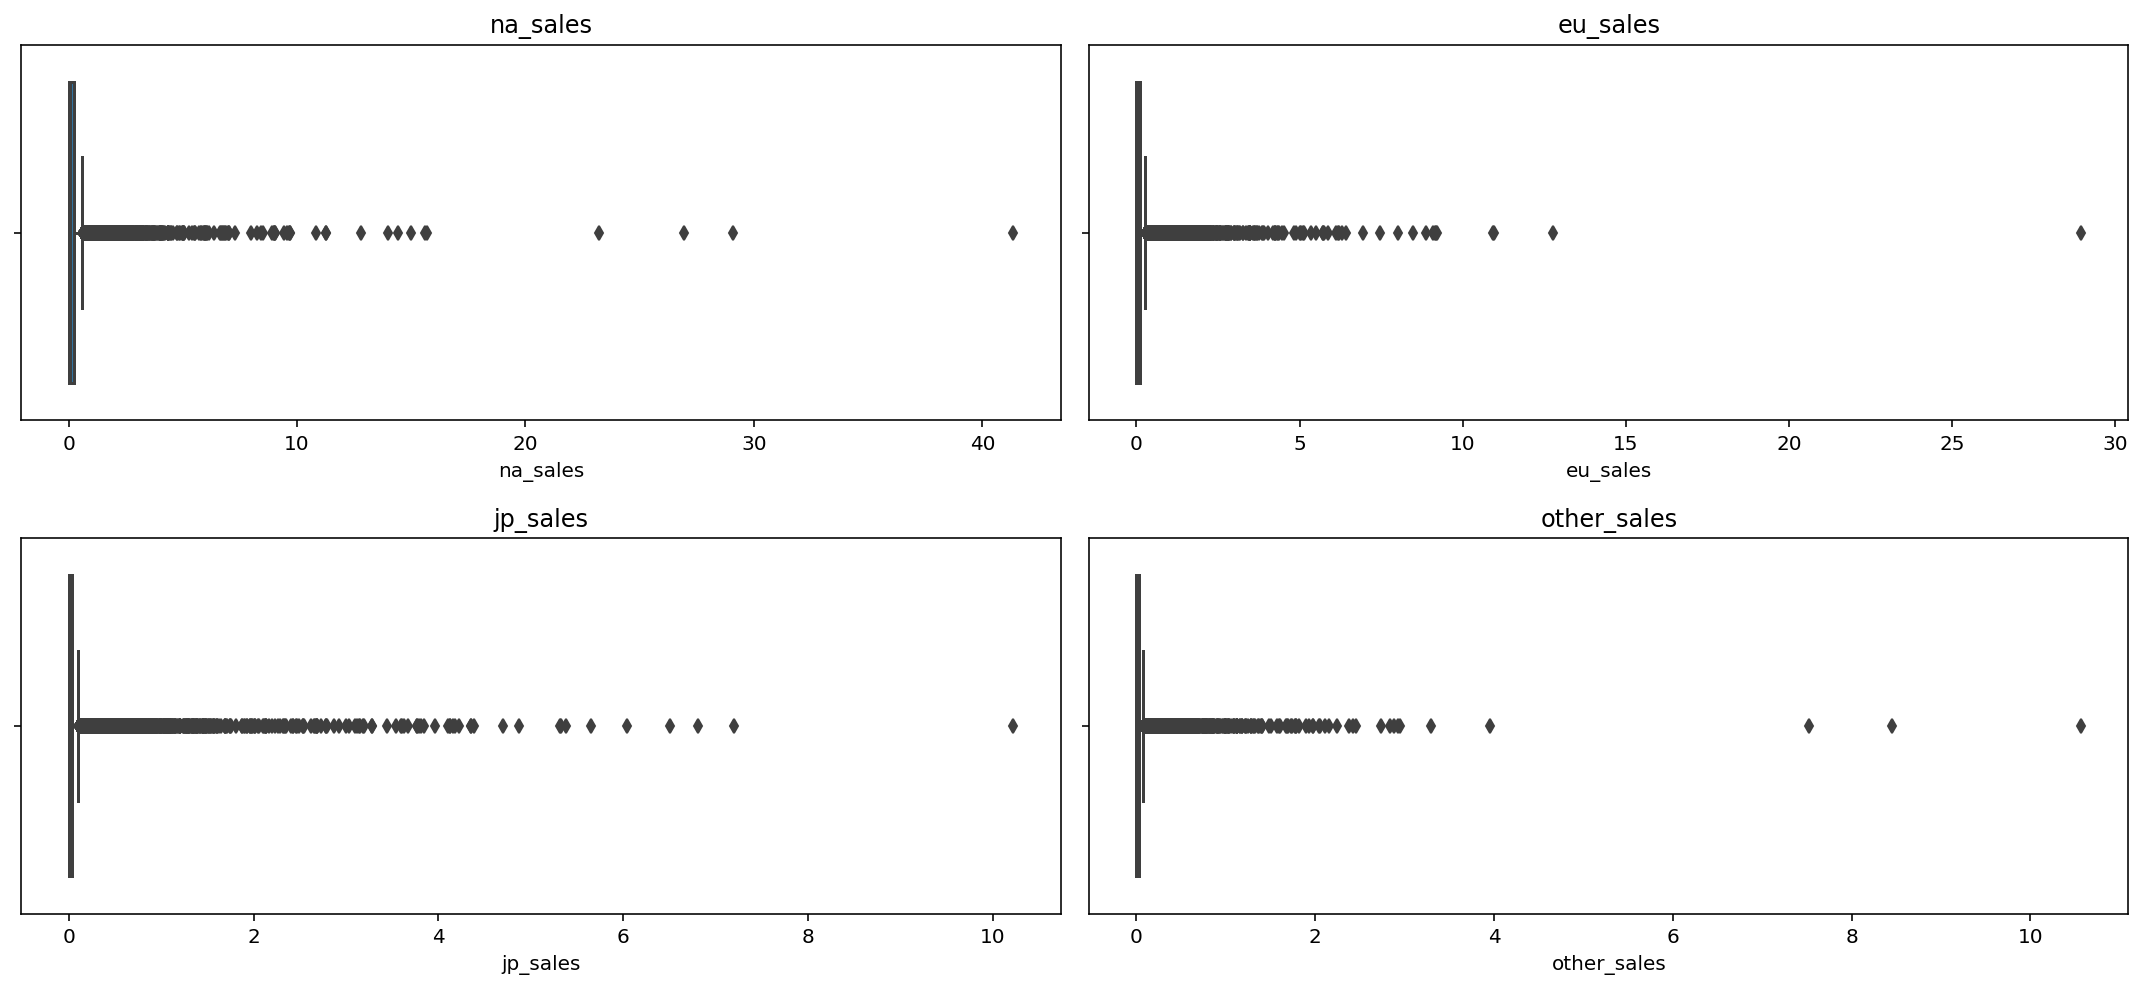

In [17]:
params = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
col_count, row_count = 2, 2

plt.figure(figsize=(15, 7))

for i, param in enumerate(params):
    sns.boxplot(games[param], ax = plt.subplot(row_count, col_count, i + 1))
    plt.title(param)
    
plt.tight_layout()

Здесь мы видим очень большие показатели выбросов и аномально высокие значения по каждому региону.

Подтвердим данные даиграмм цифрами.

In [18]:
games['na_sales'].describe()

count    16444.000000
mean         0.264012
std          0.818378
min          0.000000
25%          0.000000
50%          0.080000
75%          0.240000
max         41.360000
Name: na_sales, dtype: float64

In [19]:
games['eu_sales'].describe()

count    16444.000000
mean         0.145930
std          0.506716
min          0.000000
25%          0.000000
50%          0.020000
75%          0.110000
max         28.960000
Name: eu_sales, dtype: float64

In [20]:
games['jp_sales'].describe()

count    16444.000000
mean         0.078487
std          0.311100
min          0.000000
25%          0.000000
50%          0.000000
75%          0.040000
max         10.220000
Name: jp_sales, dtype: float64

In [21]:
games['other_sales'].describe()

count    16444.000000
mean         0.047594
std          0.188005
min          0.000000
25%          0.000000
50%          0.010000
75%          0.030000
max         10.570000
Name: other_sales, dtype: float64

По каждому региону имеются очень значительные выбросы максимальных значений продаж. Но так как они характерны для всех регионов, можно предположить, что это связано с мегапопулярными играми, которых было очень небольшое количество и которые значительно поднимали уровень продаж. Отбрасывать такие данные не имеет никаго смысла, наши выводы могут быть сильно искажены в будущем.

Предобоработка данных на этом закончена, можем переходить к исследовательскому анализу.

# 3. Исследовательский анализ данных

## 3.1. Оценка продаж по годам

Для проведения нашего анализа нам дополнительно понадобятся показатели суммарных продаж игр во всем мире. А также отдельно вычленим год выпуска игр на рынок.

In [22]:
games['sales_sum'] = games.loc[:, 'na_sales':'other_sales'].sum(axis=1)
games['year'] = pd.DatetimeIndex(games['year_of_release']).year
games.head()

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_sum,year
0,0,Wii Sports,Wii,2006-01-01,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54,2006
1,1,Super Mario Bros.,NES,1985-01-01,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24,1985
2,2,Mario Kart Wii,Wii,2008-01-01,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52,2008
3,3,Wii Sports Resort,Wii,2009-01-01,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77,2009
4,4,Pokemon Red/Pokemon Blue,GB,1996-01-01,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38,1996


Посмотрим сколько реализовывалось копий игр глобально за весь период, представленный в данных.

In [23]:
games_by_year = games.groupby('year').agg({'sales_sum':'sum'})
games_by_year

,sales_sum
year,
1980,11.38
1981,35.68
1982,28.88
1983,16.80
1984,50.35
1985,53.95
1986,37.08
1987,21.70
1988,47.21


Построим график, отображающий количество проданных копий за весь период.

(Text(0.5, 6.799999999999997, 'Год'),
 Text(3.8000000000000043, 0.5, 'Количество проданных копий, млн'))

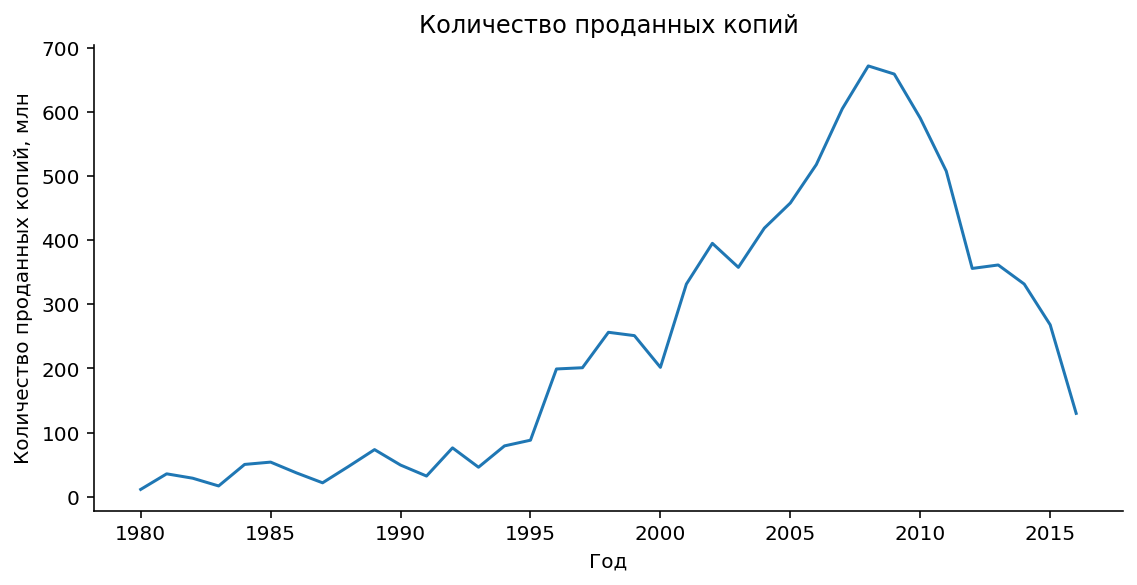

In [24]:
sns.relplot(x='year', y='sales_sum', data=games_by_year, kind='line', height=4, aspect=2)
plt.title('Количество проданных копий')
plt.xlabel('Год'), plt.ylabel('Количество проданных копий, млн')

Мы видим постпенное увеличение количества продаж до 2009 года, а затем резкое сокращение. Будем также иметь ввиду, что данные за 2016 год неполные, т.к. год еще не законичлся.

## 3.2. Оценка продаж по платфомам

Теперь посмотрим на статистику продаж игр на различных платформах.

In [25]:
games_platforms = games.groupby('platform', sort=True).agg({'sales_sum':'sum'})
games_platforms.sort_values('sales_sum', ascending=False)

,sales_sum
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


Здесь можно заключть, что самые популярные платформы это - все поколения `ps` и `xbox`, а также `Wii` и `DS`.

Рассмотрим статистику продажна шести самых популярных платформах.

In [26]:
pltfrm_list = ['PS', 'DS', 'Wii', 'PS3', 'X360', 'PS2']
games_pltfrm = (games.query('platform == @pltfrm_list')
                .groupby(['platform', 'year']).agg({'sales_sum':'sum'})
                .reset_index()
               )

Построим диаграмму распределения по полученной выборке.

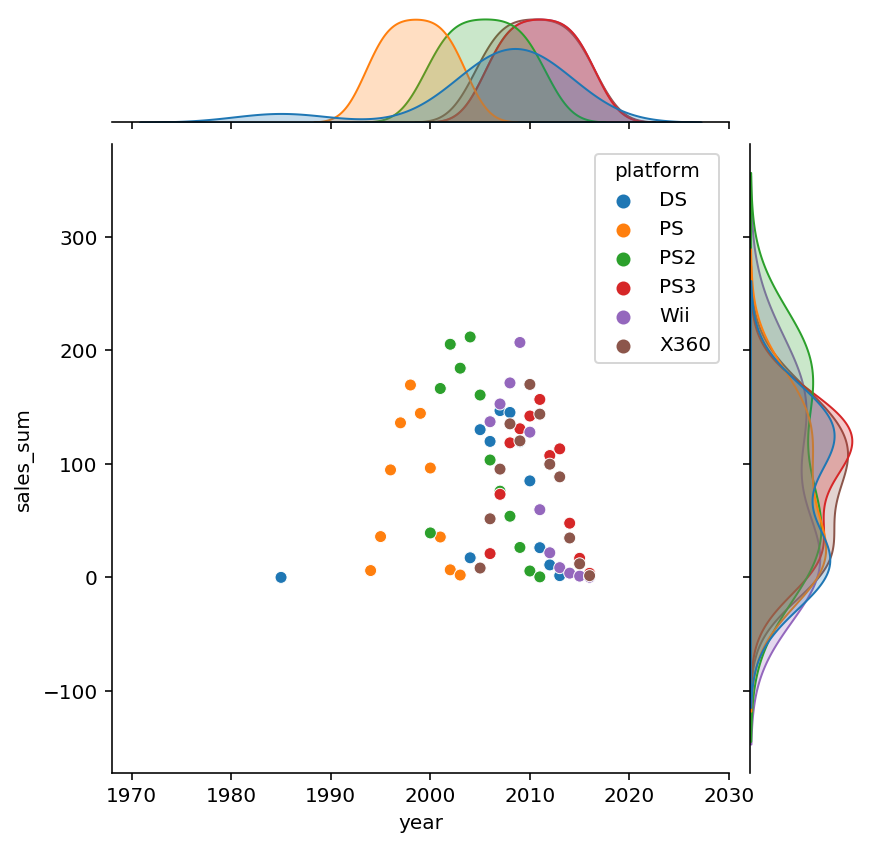

In [27]:
sns.jointplot(x='year', y='sales_sum', data=games_pltfrm, hue='platform')
plt.show()

Предварительно можем сказать, что распределение у каждой платформы имеет нормальный вид. А также хорошо видно на примере смены поколений у `PS` как меняется динамика продаж с появлением каждого нового поколения платформы.

Для большей наглядности построим график продаж по шести платформам отдельно.

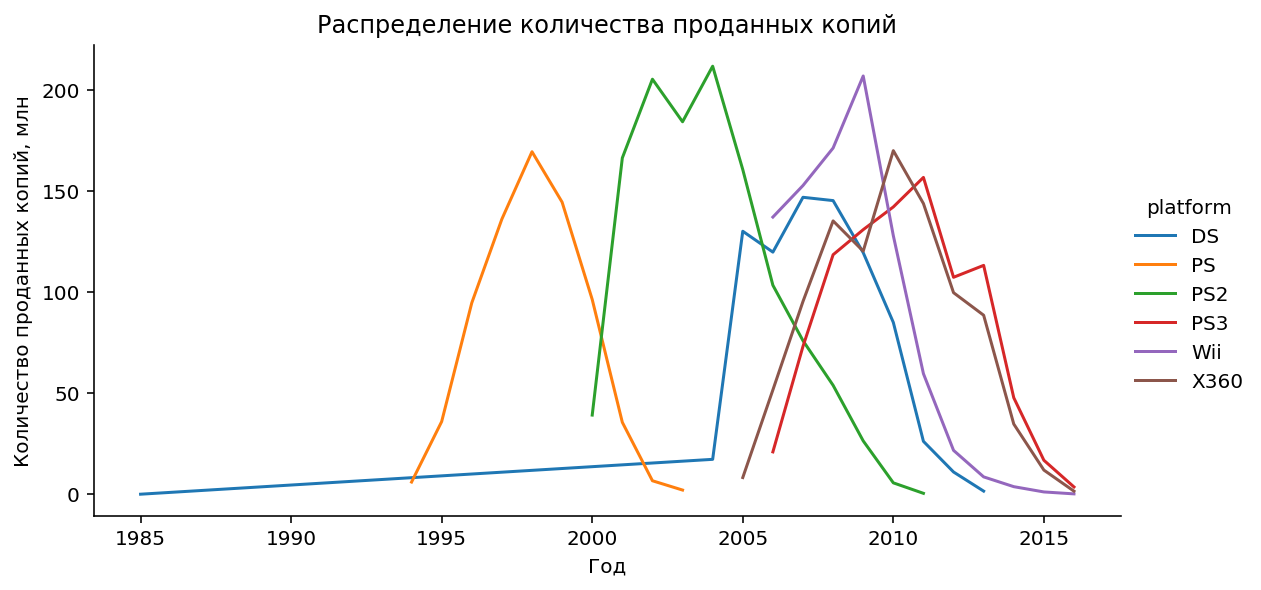

In [28]:
sns.relplot(x='year', y='sales_sum', data=games_pltfrm, hue='platform', kind='line', height=4, aspect=2)
plt.title('Распределение количества проданных копий')
plt.xlabel('Год'), plt.ylabel('Количество проданных копий, млн')
plt.show()

Здесь мы видим подтверждение нашим выводам и рсапределении количества проданных копий по платформам и общую зависимость продаж от различных поколений платформ.

Теперь нам необходимо посчитать **актуальный** период жизни платформы. Для этого мы определим, что подсчет будем проводить по данным, продажи по которым превышали 5 млн копий. Далее мы подсчитаем общее количество годов существоавания платформы с показателями продаж более 5 млн копий и разделим пополам (потому что из полученных графиков видно, что половину среднего срока жизни продажи на платформе растут, а половину падают). Поэтому корректно будет считать, что **актуальный** период составляет половину среднего срока жизни платформы.

In [29]:
pltfrm_year_lives = games.groupby(['platform', 'year']).agg({'sales_sum':'sum'}).reset_index()
pltfrm_year_lives = (pltfrm_year_lives.query('sales_sum > 5').
                groupby('platform').agg({'year':'count'})
                .reset_index()
               )
pltfrm_year_lives['year'].mean()/2

3.4583333333333335

Мы получили цифру 3,5 года - это и есть наш **актуальный период**.

Теперь мы можем посмотреть какие платформы являются наиболее востребованными на сегодняшний день.

In [30]:
games_actual = games.query('year >= 2013').reset_index()
games_actual.head()

,level_0,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_sum,year
0,16,16,Grand Theft Auto V,PS3,2013-01-01,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05,2013
1,23,23,Grand Theft Auto V,X360,2013-01-01,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27,2013
2,31,31,Call of Duty: Black Ops 3,PS4,2015-01-01,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63,2015
3,33,33,Pokemon X/Pokemon Y,3DS,2013-01-01,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60,2013
4,42,42,Grand Theft Auto V,PS4,2014-01-01,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62,2014


In [31]:
games_actual = games_actual.groupby(['platform', 'year']).agg({'sales_sum':'sum'}).reset_index()

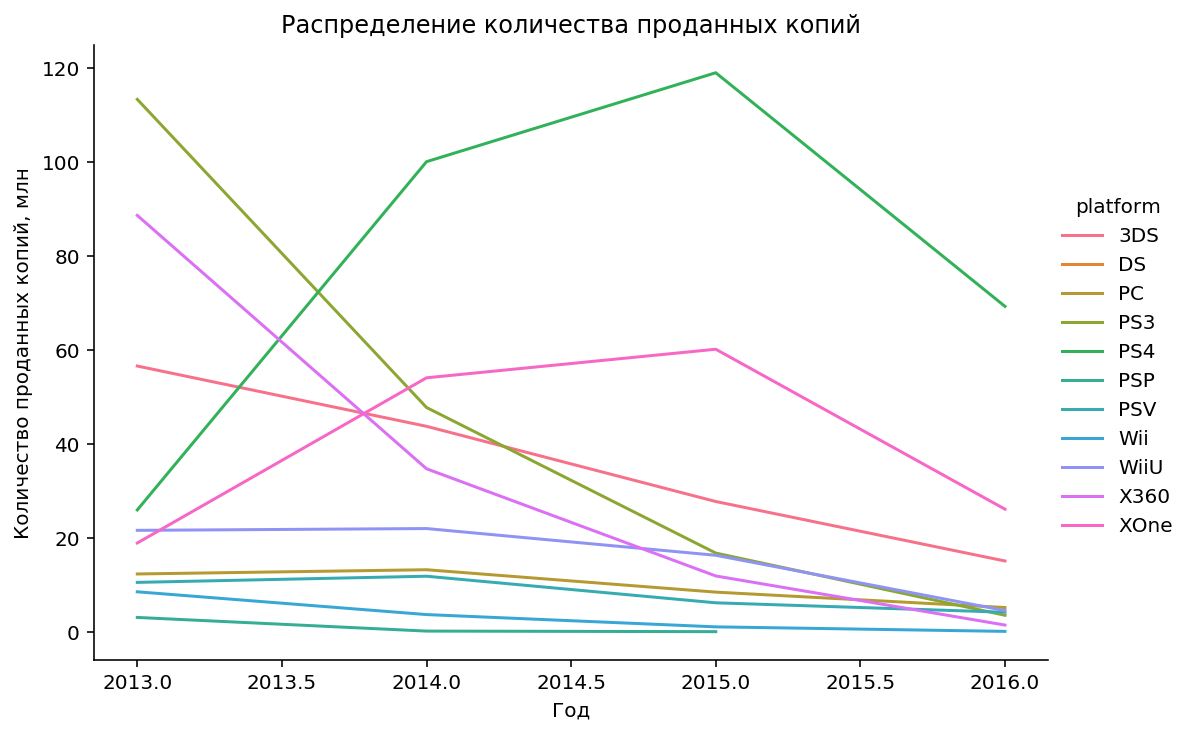

In [32]:
sns.relplot(x='year', y='sales_sum', data=games_actual, hue='platform', kind='line', height=5, aspect=1.5)
plt.title('Распределение количества проданных копий')
plt.xlabel('Год'), plt.ylabel('Количество проданных копий, млн')
plt.show()

По полученнм результатам можно предсказать, что **в данный момент платформы `PS4` и `XOne` находятся на пике своего жизненного цикла, а значит еще как минимум два года продажи игр на этих платформах будут актуальны.** В дополнении можно сказать, что хоть количество проданных копий на `PC` и невелико, но имеет довольно стабильную характеристику, а значит также может рассматриваться как потенциальная платформа для продвижения продуктов.

Построим диаграммы размаха для всех платформ за актуальный период.

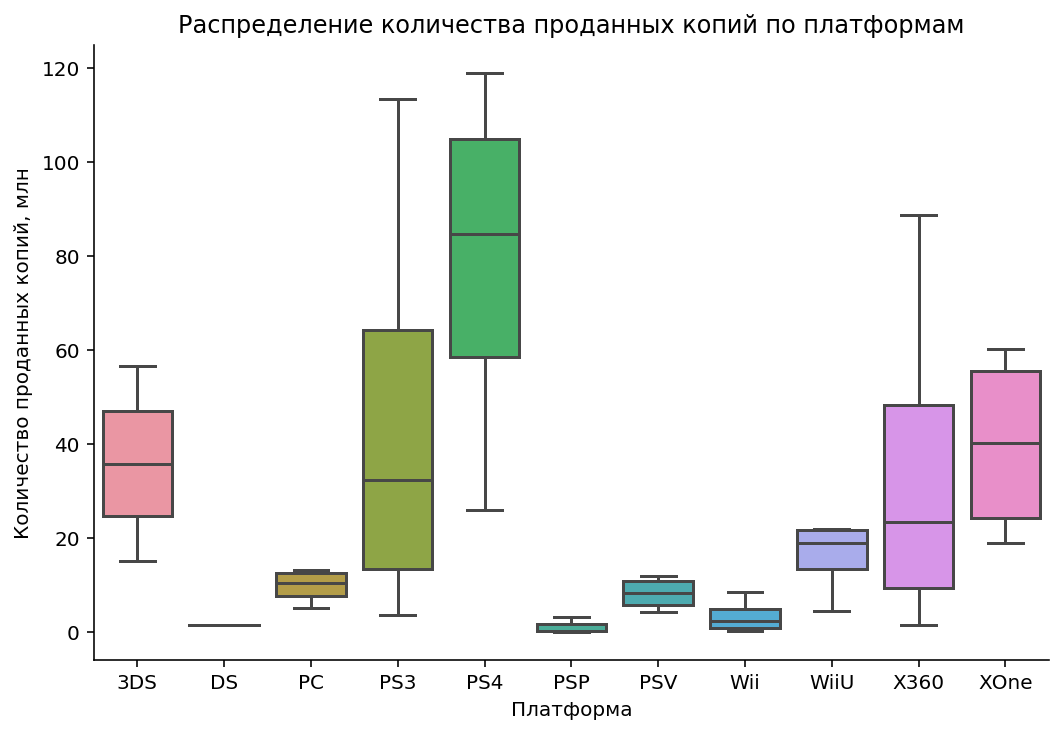

In [33]:
sns.catplot(x="platform", y="sales_sum", kind="box", data=games_actual, height=5, aspect=1.5)
plt.title('Распределение количества проданных копий по платформам')
plt.xlabel('Платформа'), plt.ylabel('Количество проданных копий, млн')
plt.show()

Из диаграмм размаха по платформам за актуальный период мы можем сделать следующие выводы:

- самые популярные платформы это различные поколения `PS` и `XBox`;
- наблюдается довольно хорошая плотность данных без сильных выбросов (только на `PC` и `Wii`).

## 3.3. Оценка влияния на продажи оценок критиков и пользователей

Для оценки влияния оценок критиков и пользователей выберем одну самую популярную платформу и сравним с показателями остальных платформ.

Из предыдущих результатов заключаем, что самая популярная игровая платформа - это `PS3`.

Сравним распределение и зависимость количества продаж от оценок критиков и пользователей в рамках одной платформы и остальных платформ.

In [34]:
pltfrm_ps3 = games.query('platform == "PS3"')
pltfrm_ps3 = pltfrm_ps3[['critic_score', 'user_score', 'sales_sum']]

In [35]:
pltfrm_not_ps3 = games.query('platform != "PS3"')
pltfrm_not_ps3 = pltfrm_not_ps3[['critic_score', 'user_score', 'sales_sum']]

Построим графики распределения зависимости количества проданных копий от оценки критиков.

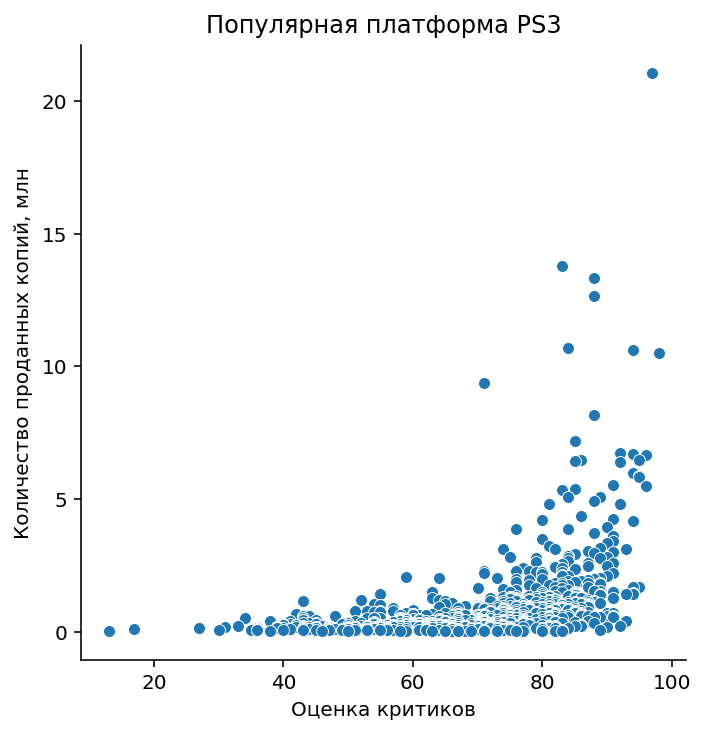

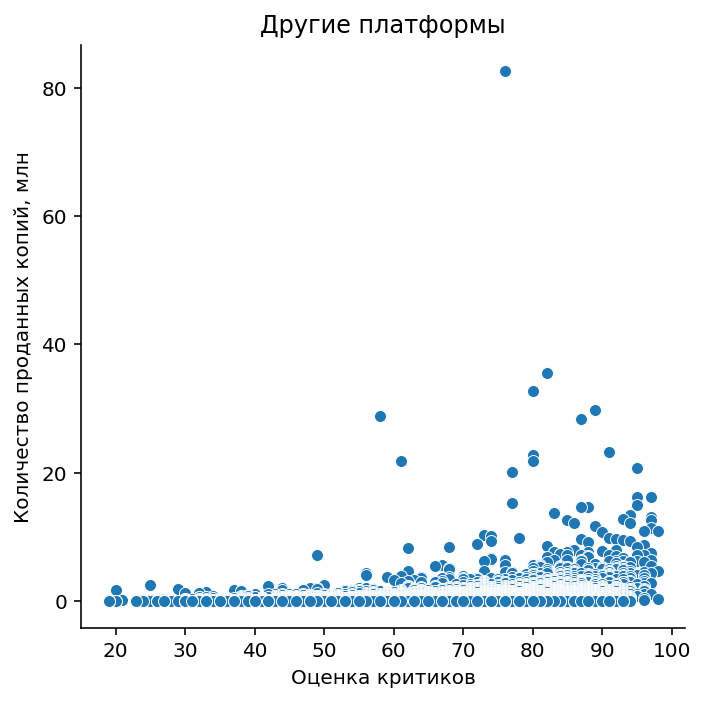

In [36]:
sns.relplot(x='critic_score', y='sales_sum', data=pltfrm_ps3)
plt.title('Популярная платформа PS3')
plt.xlabel('Оценка критиков'), plt.ylabel('Количество проданных копий, млн')
sns.relplot(x='critic_score', y='sales_sum', data=pltfrm_not_ps3)
plt.title('Другие платформы')
plt.xlabel('Оценка критиков'), plt.ylabel('Количество проданных копий, млн')
plt.tight_layout()

Также посчитаем коэффициент корреляции.

In [37]:
pltfrm_ps3['sales_sum'].corr(pltfrm_ps3['critic_score'])

0.43275895789971397

In [38]:
pltfrm_not_ps3['sales_sum'].corr(pltfrm_not_ps3['critic_score'])

0.22476763532468952

Здесь мы видим, что зависимость для платформы `PS3` прямая и более выраженна, чем зависимость для остальных платформ.

Из этого можно сделать вывод, что влияние оценки критиков на уровень продаж находится в прямой зависимости и этому следует уделить внимание.

Теперь построим графики распределения зависимости продаж от пользовательских оценок.

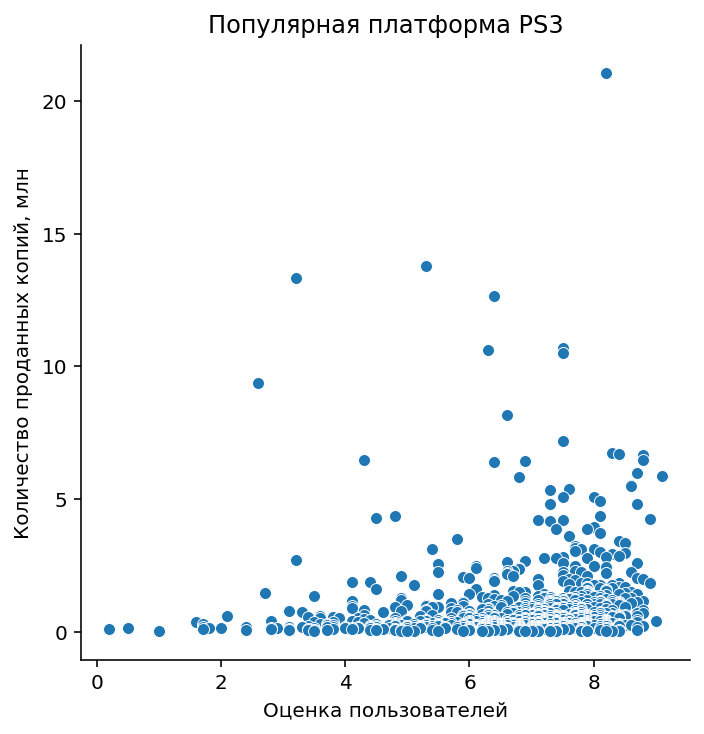

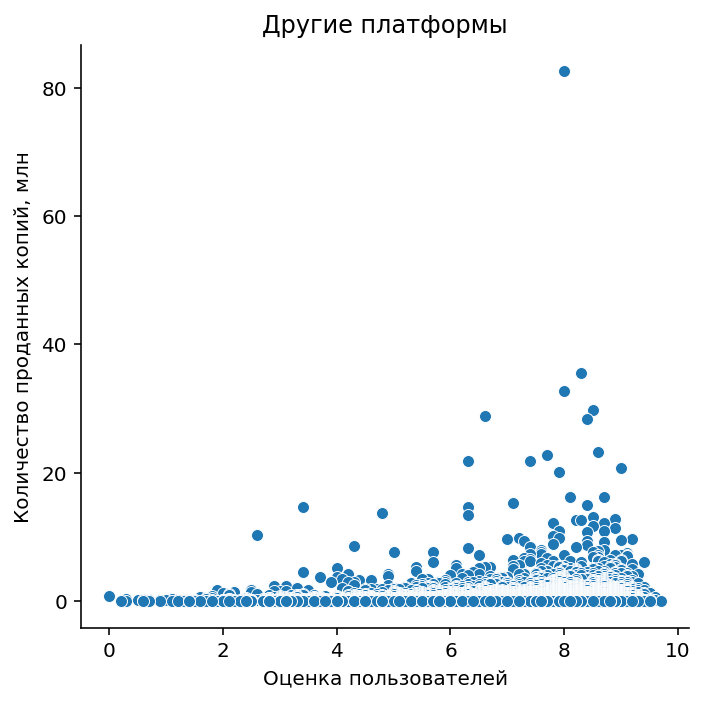

In [39]:
sns.relplot(x='user_score', y='sales_sum', data=pltfrm_ps3)
plt.title('Популярная платформа PS3')
plt.xlabel('Оценка пользователей'), plt.ylabel('Количество проданных копий, млн')
sns.relplot(x='user_score', y='sales_sum', data=pltfrm_not_ps3)
plt.title('Другие платформы')
plt.xlabel('Оценка пользователей'), plt.ylabel('Количество проданных копий, млн')
plt.tight_layout()

Посчитаем коэффициент корреляции.

In [40]:
pltfrm_ps3['sales_sum'].corr(pltfrm_ps3['user_score'])

0.12841562938563025

In [41]:
pltfrm_not_ps3['sales_sum'].corr(pltfrm_not_ps3['user_score'])

0.08884019753205995

В этом случае можно говорить об отсутствии прямой зависимости на количество продаж оценки пользователей. А следовательно пользователеи предпочитают не полагаться на оценки других пользователей при выборе игры, а учитывать другие факторы и критерии.

## 3.4. Оценка продаж игр в различных жанрах

Теперь найдем какие жанры игр популярны среди пользователей, насколько стабильны показатели и какие самые востребованные на текущий период жанры.

Посчитаем количество проданных копий по игровым жанрам за все время.

In [42]:
games_genre = games.groupby('genre').agg({'sales_sum':'sum'})
games_genre.sort_values('sales_sum', ascending=False).reset_index()

,genre,sales_sum
0,Action,1716.52
1,Sports,1309.67
2,Shooter,1041.36
3,Role-Playing,931.08
4,Platform,825.55
5,Misc,790.29
6,Racing,723.49
7,Fighting,442.66
8,Simulation,387.96
9,Puzzle,239.89


Самые популярные жанры среди пользователей за все время это `Action`, `Sports`, `Shooter` и `Role-Playing` игры.

Построим график количества продаж по годам для различных жанров.

In [43]:
games_genre_plt = games.groupby(['genre', 'year']).agg({'sales_sum':'sum'}).reset_index()

(Text(0.5, 20.80000000000001, 'Год'),
 Text(26.562037037037044, 0.5, 'Количество копий, млн'))

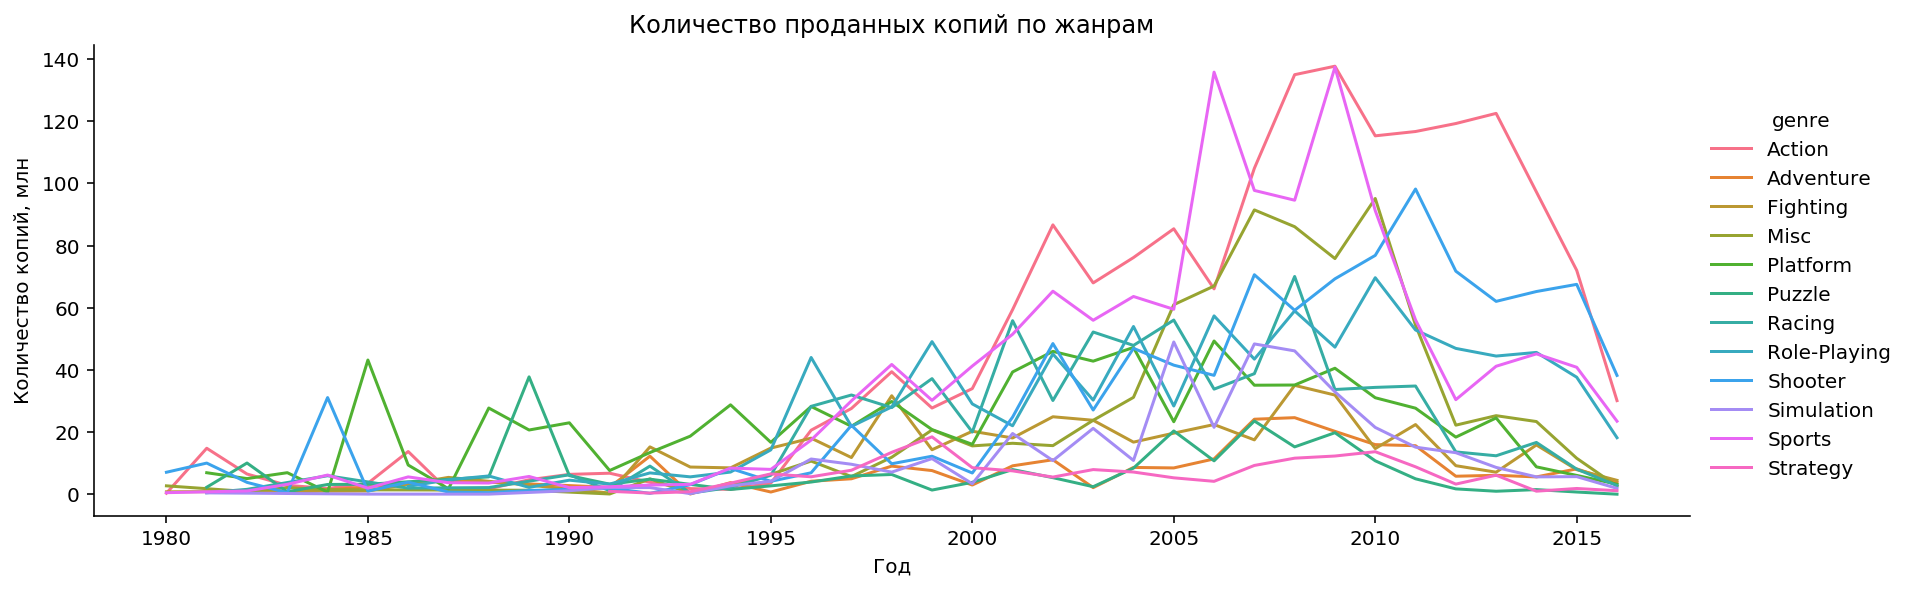

In [44]:
sns.relplot(x='year', y='sales_sum', data=games_genre_plt, hue='genre', kind='line', height=4, aspect=3)
plt.title('Количество проданных копий по жанрам')
plt.xlabel('Год'), plt.ylabel('Количество копий, млн')

А также построим график продаж игр различных жанров за актуальный период.

(Text(0.5, 20.80000000000001, 'Год'),
 Text(29.44305555555556, 0.5, 'Количество копий, млн'))

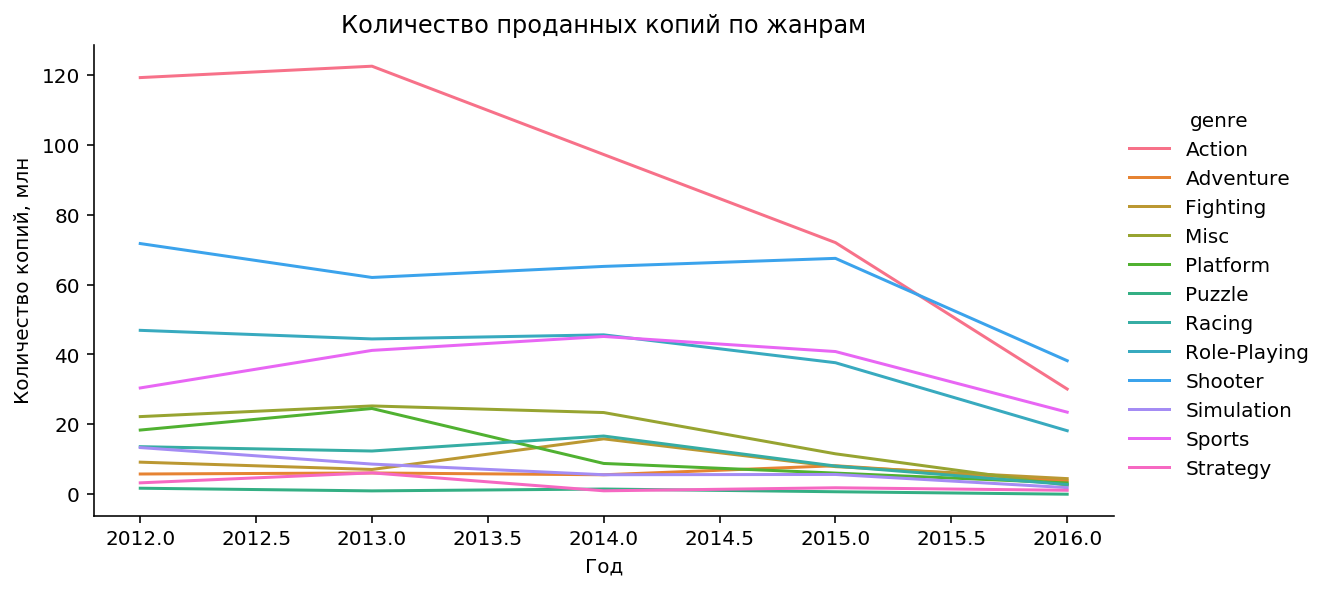

In [45]:
sns.relplot(x='year', y='sales_sum', data=games_genre_plt.query('year > 2011'), hue='genre', kind='line', height=4, aspect=2)
plt.title('Количество проданных копий по жанрам')
plt.xlabel('Год'), plt.ylabel('Количество копий, млн')

На обоих графиках мы видим общий тренд на снижение количества проданных копий игр для всех жанров. А также неоспоримое лидерство среди всех жанров уже выделенных нами `Action`, `Sports`, `Shooter` и `Role-Playing`. 

Вывод: **самыми популярными играми являются игры в жанрах `Action`, `Sports`, `Shooter` и `Role-Playing`.** Именно на них стоит в первую очередь делать ставку в продвижении нового продукта.

Для более точного анализа проведем сравнение медианных и средних значений количества проданных копий по различным жанрам.

Для этого выполним две группировки таблиц с подсчетом средних и медианных значений и построим два графика: за все время наблюдений и за актуальный период.

Первым делом, выполним эти действия с медианными значениями.

In [46]:
games_genre_med = games.groupby(['genre', 'year']).agg({'sales_sum':'median'}).reset_index()

(Text(0.5, 20.80000000000001, 'Год'),
 Text(25.130034722222234, 0.5, 'Количество копий, млн'))

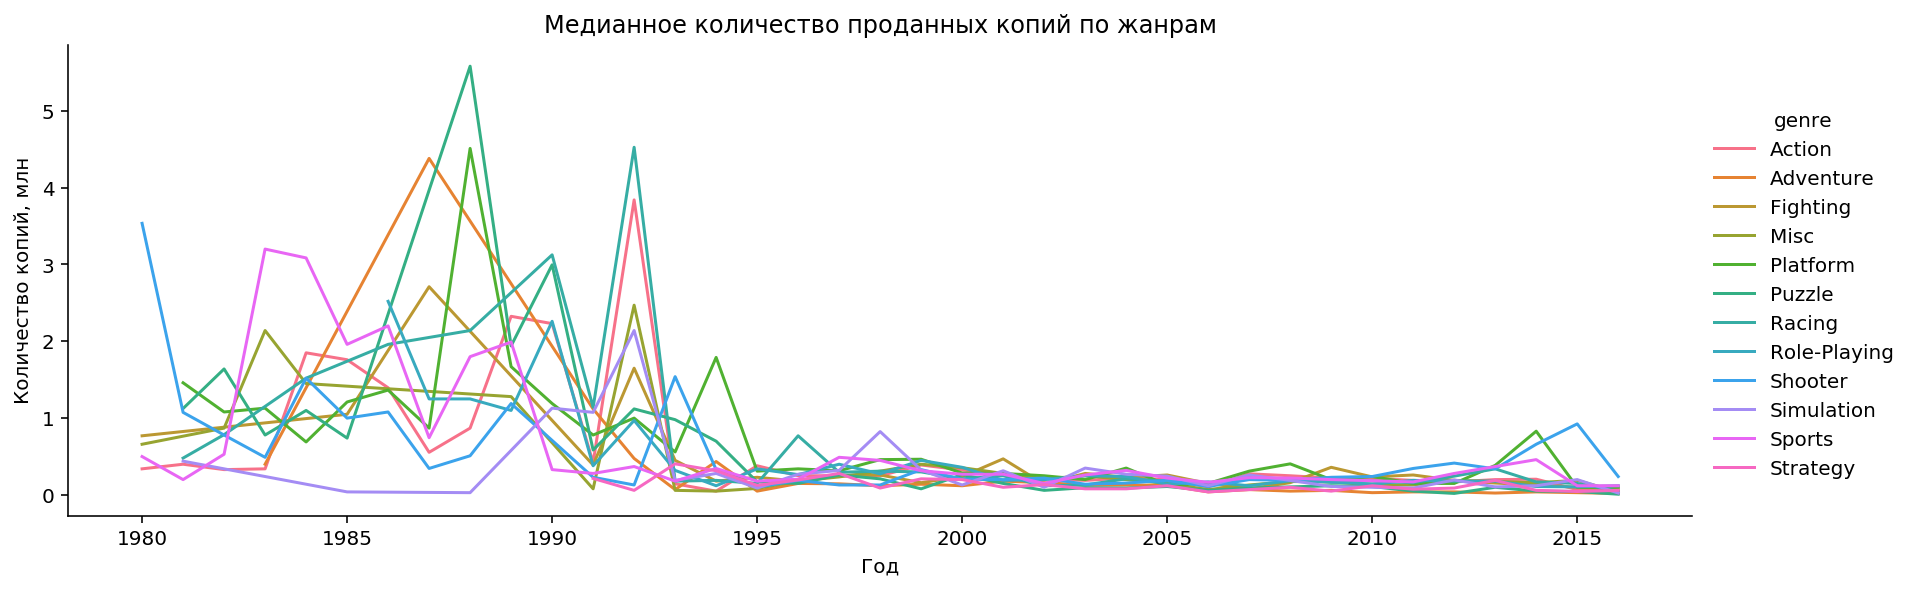

In [47]:
sns.relplot(x='year', y='sales_sum', data=games_genre_med, hue='genre', kind='line', height=4, aspect=3)
plt.title('Медианное количество проданных копий по жанрам')
plt.xlabel('Год'), plt.ylabel('Количество копий, млн')

(Text(0.5, 20.80000000000001, 'Год'),
 Text(26.207581018518525, 0.5, 'Количество копий, млн'))

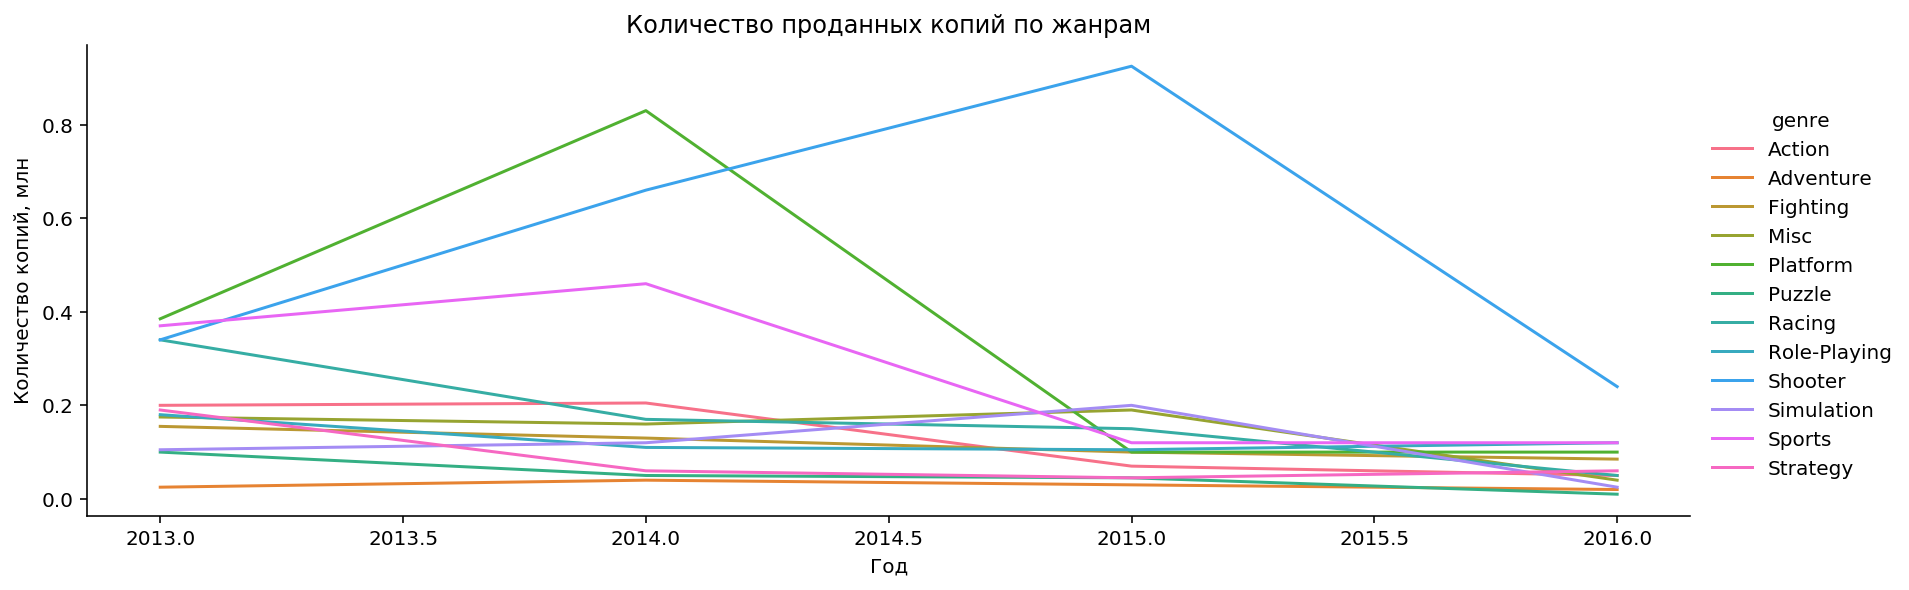

In [48]:
sns.relplot(x='year', y='sales_sum', data=games_genre_med.query('year >= 2013'), hue='genre', kind='line', height=4, aspect=3)
plt.title('Количество проданных копий по жанрам')
plt.xlabel('Год'), plt.ylabel('Количество копий, млн')

В лидирующих позициях сохранились только игры жанра `shooter` и отчасти `sports`. Зато также большой успех игры жанра `platform`.

Теперь проверим эти выводы построив сравнив количество продаж игр по различным жанрам по средним значениям.

In [49]:
games_genre_mean = games.groupby(['genre', 'year']).agg({'sales_sum':'mean'}).reset_index()

(Text(0.5, 20.80000000000001, 'Год'),
 Text(25.838946759259265, 0.5, 'Количество копий, млн'))

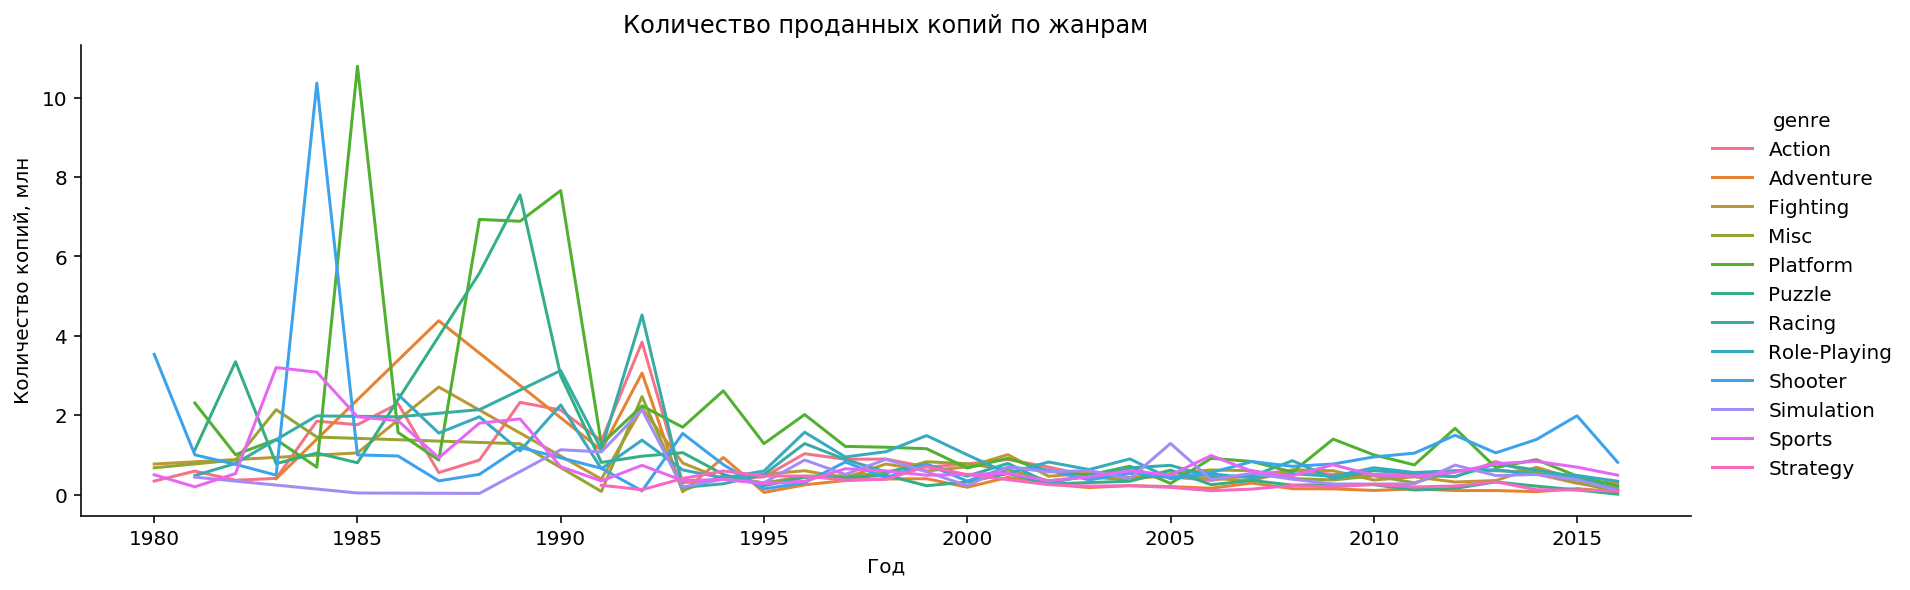

In [50]:
sns.relplot(x='year', y='sales_sum', data=games_genre_mean, hue='genre', kind='line', height=4, aspect=3)
plt.title('Количество проданных копий по жанрам')
plt.xlabel('Год'), plt.ylabel('Количество копий, млн')

(Text(0.5, 20.80000000000001, 'Год'),
 Text(26.94484953703703, 0.5, 'Количество копий, млн'))

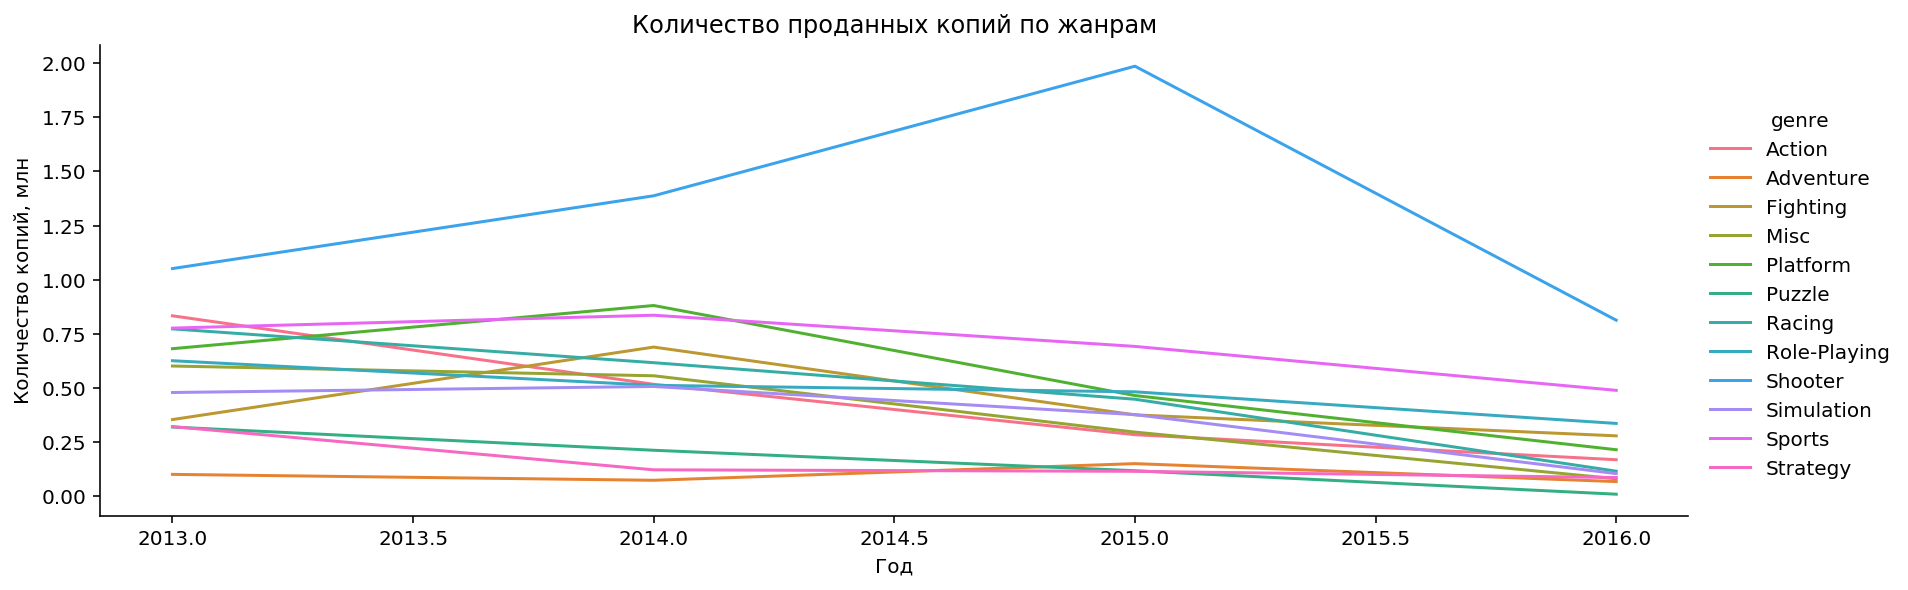

In [51]:
sns.relplot(x='year', y='sales_sum', data=games_genre_mean.query('year >= 2013'), hue='genre', kind='line', height=4, aspect=3)
plt.title('Количество проданных копий по жанрам')
plt.xlabel('Год'), plt.ylabel('Количество копий, млн')

Здесь мы видим похожую картину: уверенно первое место по популярности занимают игры жанра `shooter`, далее следуют `sports` и `platform` с небольшим отрывом от остальных жанров.

На основании новых результатов анализа делаем наш окончательный вывод: **самыми популярными играми среди пользователей являются игры жанра `shooter`, также к популярным можно отнести игры жанров `sports` и  `platform`.**

Имеено на них можно сконцетрировать наше основное внимание.

# 4. Составление портрета пользователя каждого региона

На этом этапе нам необходимо составить портрет среднего пользователя из различных регионов для наилучшего продвижения продуктов в разных частях мира. Здесь мы будем рассматривать предпочтения среднего пользователя по используемым платформам, популярным жанрам, а также посмотрим на зависимость количества продаж игр от рейтинга `ESRB`.

Напомним, что в нашем исследовании мы рассматриваем данные за акутальный период.

Также, чтобы не потерять важные данные, заменим пустые значения в рейтингах на `unknown`.

In [52]:
games_act = (games.query('year >= 2013').
             fillna('unknown').reset_index()
            )
games_act.head()

,level_0,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_sum,year
0,16,16,Grand Theft Auto V,PS3,2013-01-01,Action,7.02,9.09,0.98,3.96,97,8.2,M,21.05,2013
1,23,23,Grand Theft Auto V,X360,2013-01-01,Action,9.66,5.14,0.06,1.41,97,8.1,M,16.27,2013
2,31,31,Call of Duty: Black Ops 3,PS4,2015-01-01,Shooter,6.03,5.86,0.36,2.38,unknown,unknown,unknown,14.63,2015
3,33,33,Pokemon X/Pokemon Y,3DS,2013-01-01,Role-Playing,5.28,4.19,4.35,0.78,unknown,unknown,unknown,14.60,2013
4,42,42,Grand Theft Auto V,PS4,2014-01-01,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62,2014


## 4.1. Предпочтения пользователей среди игровых платформ

Выделим и сгруппируем данные по платформам.

In [53]:
users_pltfrm = (games_act.groupby('platform')
                .agg({'na_sales':'sum', 'eu_sales':'sum', 'jp_sales':'sum', 'other_sales':'sum'})
               )
users_pltfrm

,na_sales,eu_sales,jp_sales,other_sales
platform,,,,
3DS,38.20,30.96,67.81,6.28
DS,0.57,0.85,0.00,0.12
PC,11.11,25.36,0.00,2.96
PS3,63.50,67.81,23.35,26.77
PS4,108.74,141.09,15.96,48.35
PSP,0.00,0.17,3.29,0.04
PSV,5.04,6.10,18.59,3.26
Wii,6.56,5.93,0.05,1.12
WiiU,29.21,19.85,10.88,4.69


Также для большей корректности выводов приведем данные по медианным значениям количества продаж.

In [54]:
users_pltfrm_med = (games_act.groupby('platform')
                .agg({'na_sales':'median', 'eu_sales':'median', 'jp_sales':'median', 'other_sales':'median'})
               )

Построим графики количесвта продаж по платформам по разичным регионам.

(Text(0.5, 20.80000000000001, 'Платформы'),
 Text(26.2754050925926, 0.5, 'Количество копий, млн'))

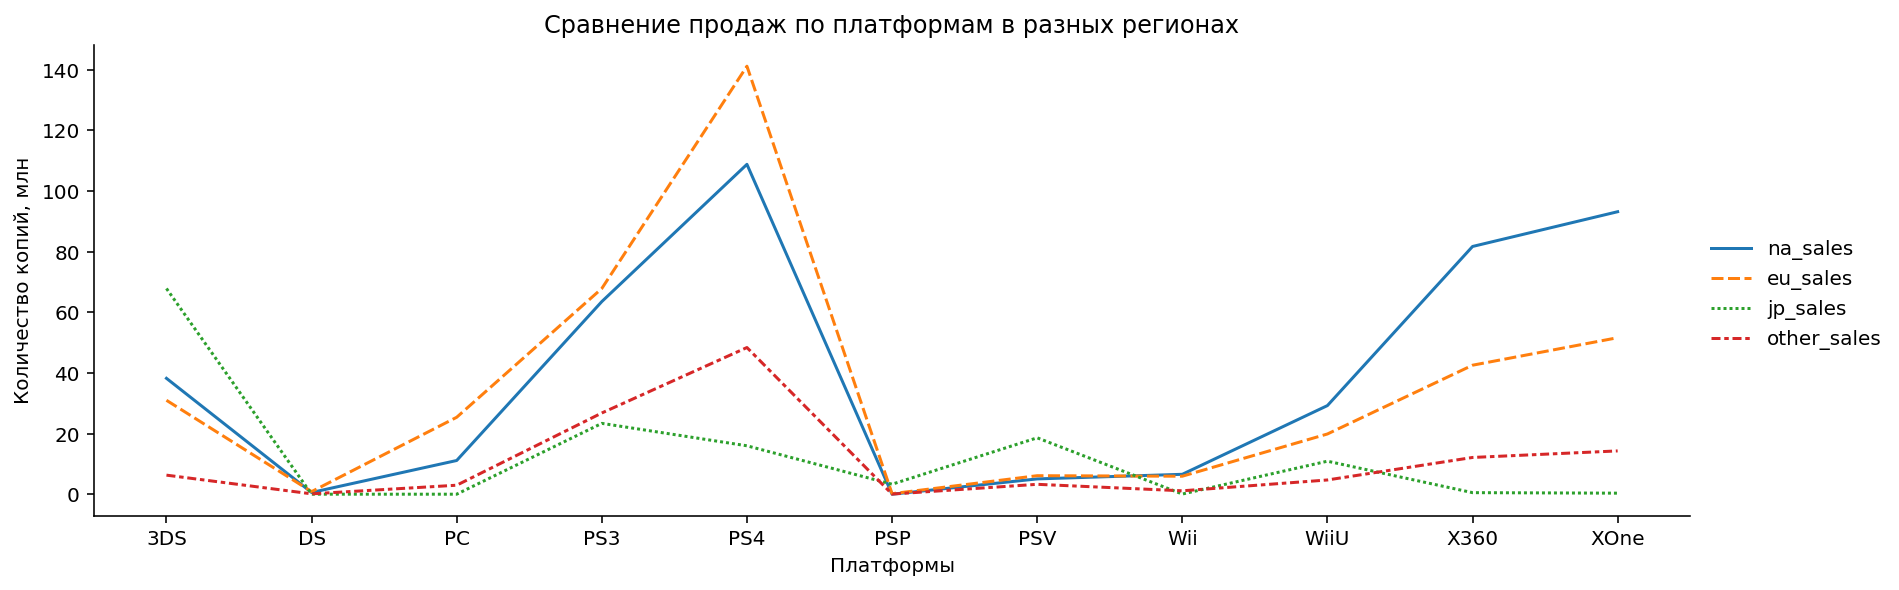

In [55]:
sns.relplot(data=users_pltfrm, kind='line', height=4, aspect=3)
plt.title('Сравнение продаж по платформам в разных регионах')
plt.xlabel('Платформы'), plt.ylabel('Количество копий, млн')

(Text(0.5, 20.80000000000001, 'Платформы'),
 Text(26.625701678240745, 0.5, 'Количество копий, млн'))

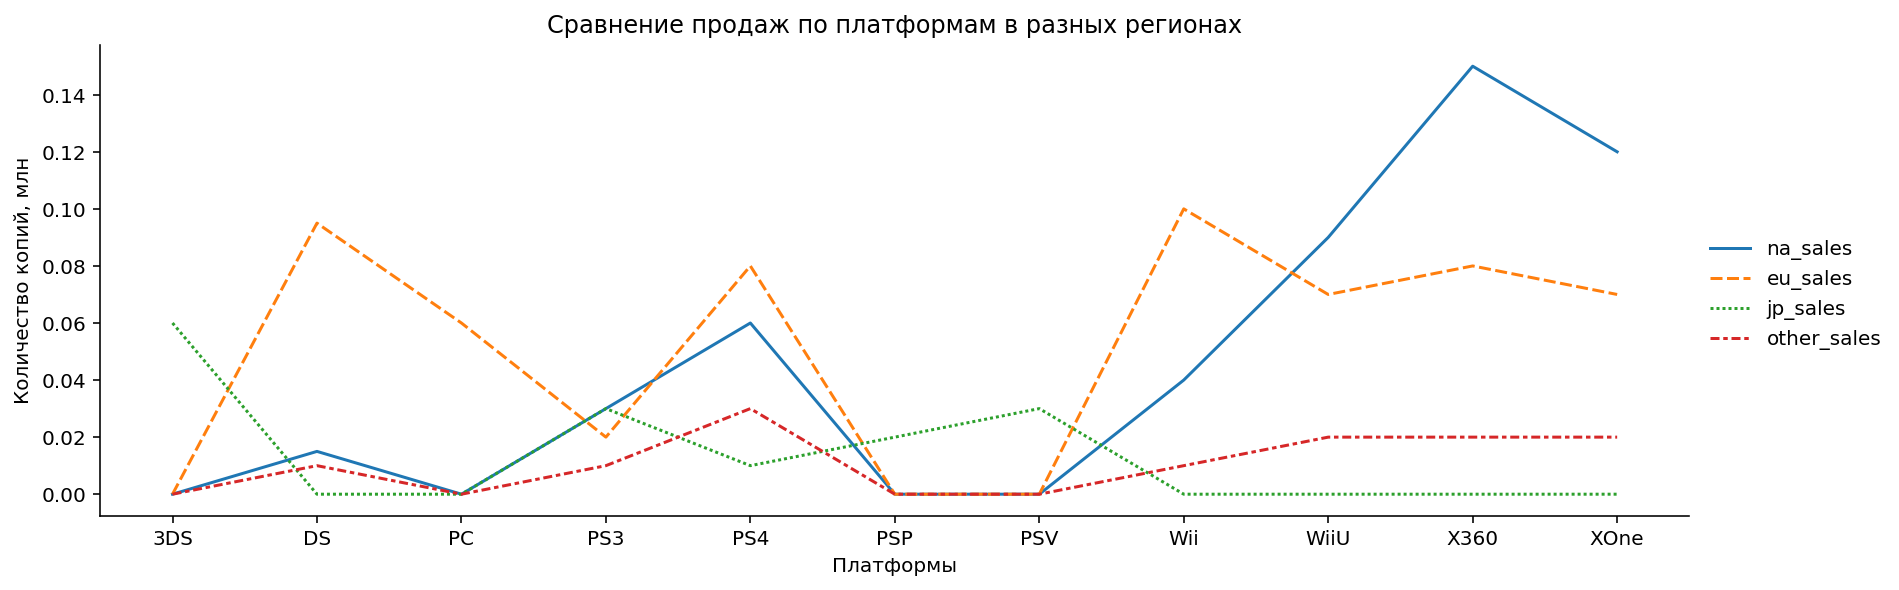

In [56]:
sns.relplot(data=users_pltfrm_med, kind='line', height=4, aspect=3)
plt.title('Сравнение продаж по платформам в разных регионах')
plt.xlabel('Платформы'), plt.ylabel('Количество копий, млн')

Можно выявить явную закономерность по самым популярным платформам - это различные поколения `PS` (кроме портативных платформ) и `XBox`, а также `DS` и `Wii`. 

По средним показателям поведение пользователей из Европы отличается от пользователей из Северной Америки - в Европе предпочтение также отдают платформам `DS` и `Wii`.

Также необходимо отметить отличия в предпочтениях пользователей из других регионов от остальных пользователей. Жители Японии  отдают предпочтение всем продуктам `PS`.

А пользователеи из Японии активно используют платформы `3DS`, `PS3` и `PSV`.

## 4.2. Предпочтения пользователей среди игровых жанров

Теперь посмотрим на поведение пользователей касаемо игровых жанров.

In [57]:
users_genre = (games_act.groupby('genre')
               .agg({'na_sales':'sum', 'eu_sales':'sum', 'jp_sales':'sum', 'other_sales':'sum'})
              )
users_genre

,na_sales,eu_sales,jp_sales,other_sales
genre,,,,
Action,126.05,118.13,40.49,37.20
Adventure,7.14,8.25,5.82,2.43
Fighting,15.55,8.55,7.65,3.56
Misc,27.49,20.04,9.20,6.09
Platform,18.14,15.58,4.79,4.12
Puzzle,0.83,1.00,1.18,0.16
Racing,12.96,20.19,2.30,4.44
Role-Playing,46.40,36.97,51.04,11.48
Shooter,109.74,87.86,6.61,28.77


Здесь также добавим сравнение количества продаж по жанрам по медианным значениям.

In [58]:
users_genre_med = (games_act.groupby('genre')
               .agg({'na_sales':'median', 'eu_sales':'median', 'jp_sales':'median', 'other_sales':'median'})
              )

Построим график зависимости количества продаж от игрового жанра.

(Text(0.5, 20.80000000000001, 'Игровые жанры'),
 Text(26.2754050925926, 0.5, 'Количество копий, млн'))

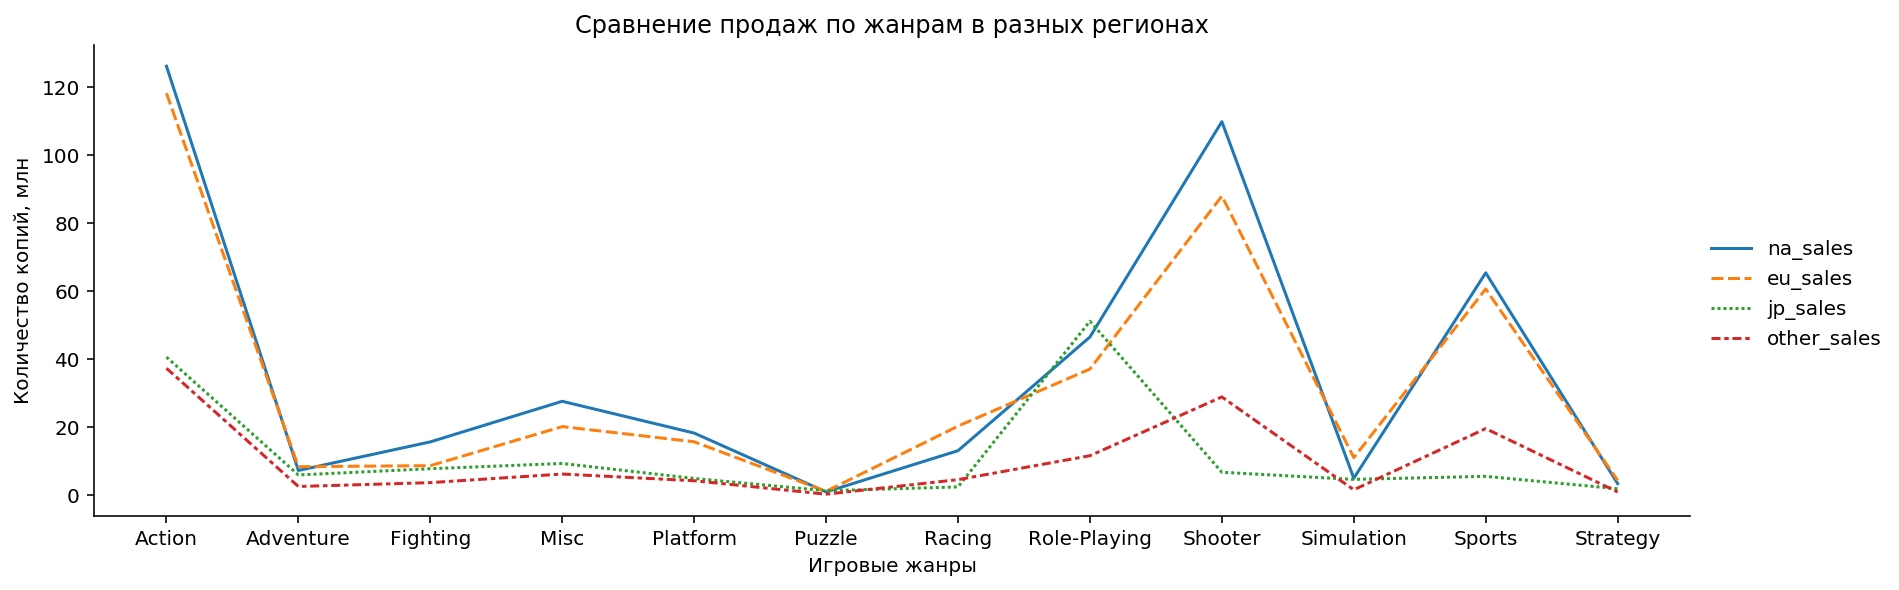

In [59]:
sns.relplot(data=users_genre, kind='line', height=4, aspect=3)
plt.title('Сравнение продаж по жанрам в разных регионах')
plt.xlabel('Игровые жанры'), plt.ylabel('Количество копий, млн')

(Text(0.5, 20.80000000000001, 'Игровые жанры'),
 Text(27.312821903935188, 0.5, 'Количество копий, млн'))

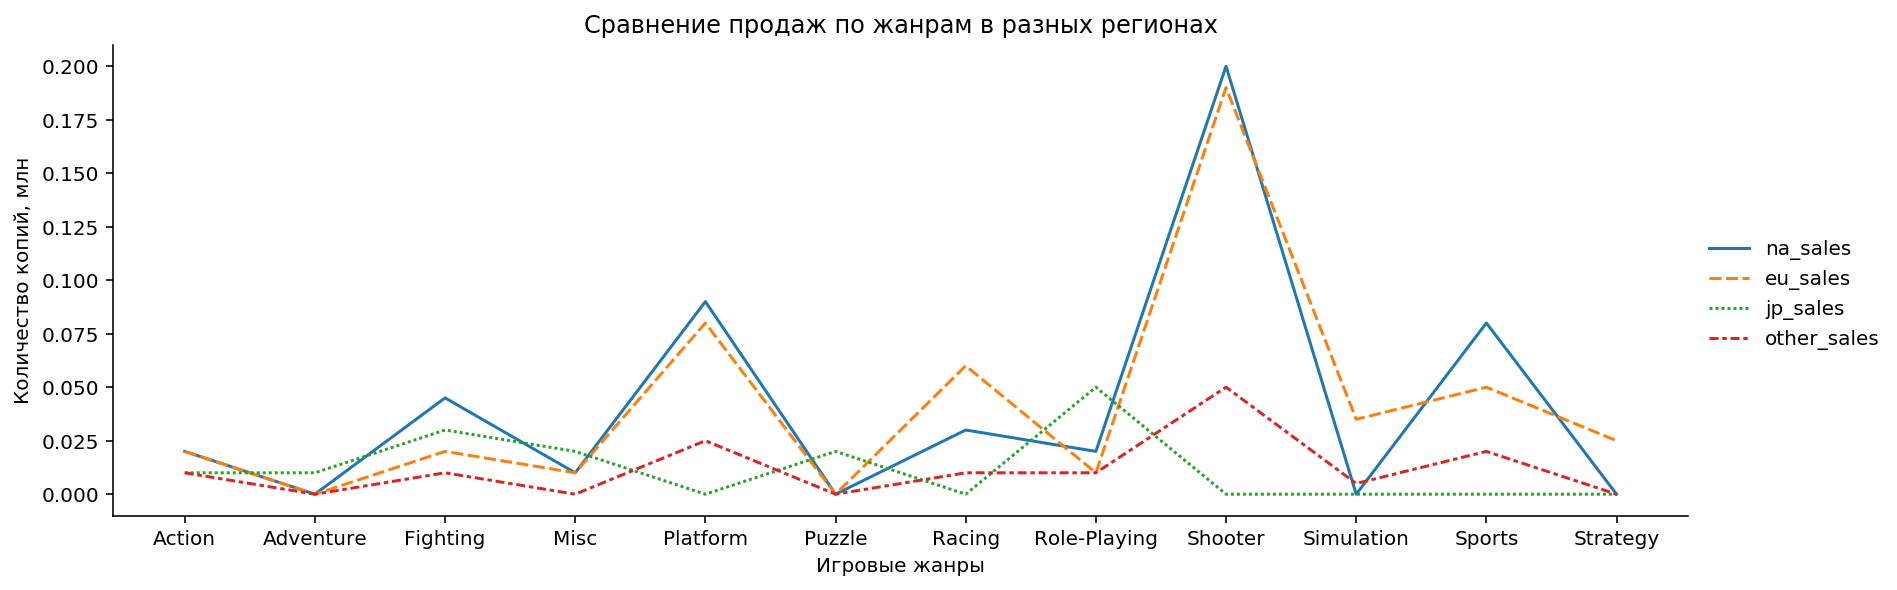

In [60]:
sns.relplot(data=users_genre_med, kind='line', height=4, aspect=3)
plt.title('Сравнение продаж по жанрам в разных регионах')
plt.xlabel('Игровые жанры'), plt.ylabel('Количество копий, млн')

Пользователи из Северной Америки, Европы и других регионов ведут себя одиноково, предпочитая игры в жанрах `Fighting`, `Platform`, `Shooter` и `Sports`. В Европе также популярными являются игры жанра `Racing`.  Хотя в других регионах кривая сравнения продаж и не такая ярко выраженная.

А вот среди пользователей из Японии популярными являются игры `Role-Playing`, `Fighting` и `Puzzle`, а остальные жанры находятся на примерно одинаковом уровне востребованности.

## 4.3. Предпочтения пользователей в зависимости от рейтинга `ESRB`

А теперь рассмотрим зависимость количества продаж от рейтинга `ESRB`. 

Entertainment Software Rating Board (ESRB) — негосударственная организация, основное направление деятельности — принятие и определение рейтингов для компьютерных видеоигр и другого развлекательного программного обеспечения в США и Канаде. К началу 2003 года рейтинги ESRB получили более 8000 продуктов от 350 издателей.

Рейтинг `ESRB` представляет собой возрастную оценку компьютерных игр по установленной шкале:

- «EC» («Early childhood») — «Для детей младшего возраста»;
- «E» («Everyone») — «Для всех»;
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»;
- «T» («Teen») — «Подросткам»;
- «M» («Mature») — «Для взрослых»;
- «AO» («Adults Only 18+») — «Только для взрослых»;
- «RP» («Rating Pending») — «Рейтинг ожидается».

In [61]:
users_esrb = (games_act.groupby('rating')
              .agg({'na_sales':'sum', 'eu_sales':'sum', 'jp_sales':'sum', 'other_sales':'sum'})
             )
users_esrb

,na_sales,eu_sales,jp_sales,other_sales
rating,,,,
E,79.05,83.36,15.14,22.61
E10+,54.24,42.69,5.89,12.57
M,165.21,145.32,14.11,47.04
T,49.79,41.95,20.59,14.29
unknown,89.42,78.91,85.05,23.46


Здесь также проведем сравнительный анализ по медианным значениям продаж.

In [62]:
users_esrb_med = (games_act.groupby('rating')
              .agg({'na_sales':'median', 'eu_sales':'median', 'jp_sales':'median', 'other_sales':'median'})
             )

Как мы видим за актуальный период игры получали оценки только по 4м категориям.

(Text(0.5, 20.80000000000001, 'Рейтинг'),
 Text(29.01310763888889, 0.5, 'Количество копий, млн'))

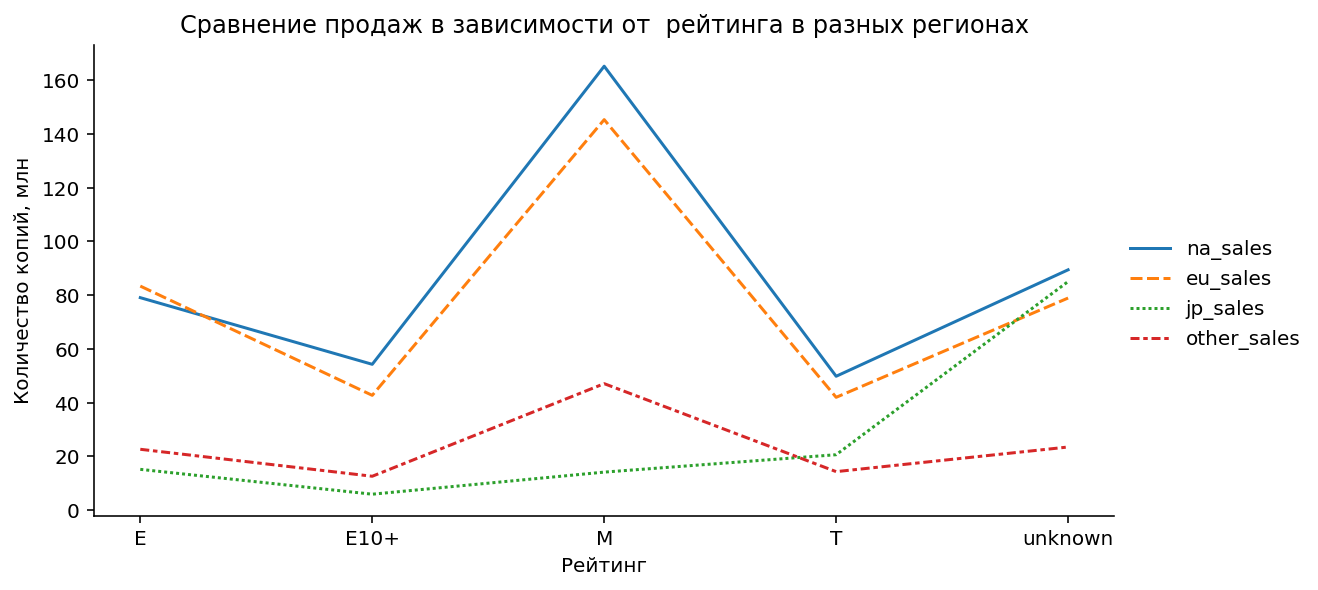

In [63]:
sns.relplot(data=users_esrb, kind='line', height=4, aspect=2)
plt.title('Сравнение продаж в зависимости от  рейтинга в разных регионах')
plt.xlabel('Рейтинг'), plt.ylabel('Количество копий, млн')

(Text(0.5, 20.80000000000001, 'Рейтинг'),
 Text(29.53855251736111, 0.5, 'Количество копий, млн'))

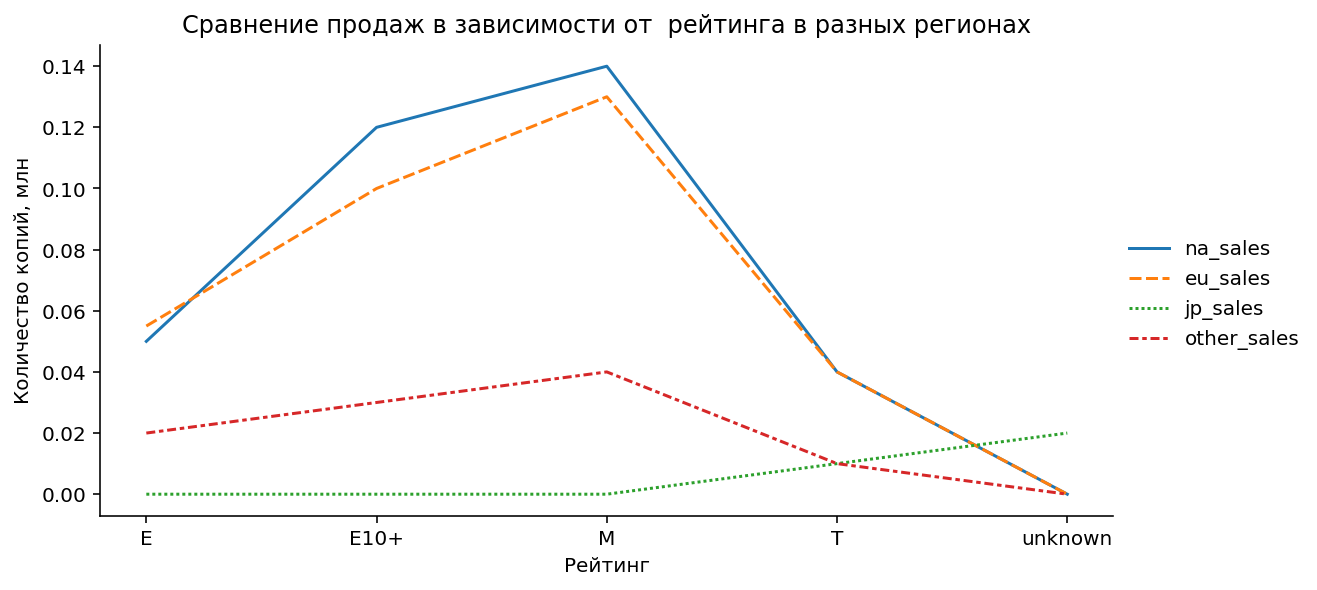

In [64]:
sns.relplot(data=users_esrb_med, kind='line', height=4, aspect=2)
plt.title('Сравнение продаж в зависимости от  рейтинга в разных регионах')
plt.xlabel('Рейтинг'), plt.ylabel('Количество копий, млн')

Из полученного графика зависимости видим, что самыми популярными играми во всех регионах кроме Японии были игры с рейтингом `M`, а самыми непопулярными игры с рейтнгом `T` и `E`.

Поведение пользователей в Японии снова отличается от остального мира. Здесь наиболее популярными играми были игры без рейтинга и с рейтингом  `T`, остальные игры находятся на одном уровне..

## 4.4. Общий портрет пользователей из различных регионов

Итак, составим портрет среднего пользователя по различным регионам.

- Пользоваттели из Северной Америки, Европы и остальных регинов планеты, кроме Японии, ведут себя примерно одинаково. Имеется лишь небольшая разница в количестве проданных копий. **Итак, этот пользователь предпочитает игровые платформы `PS` и `XBox` различных поколений и приобретает игры жанров `Fighting`, `Shooter` и `Platform` с рейтингом `ESRB` `M`(mature-для взрослых) и `E10+` в подавляющем большинстве случаев.**

- Дополнительно следует обязательно выделить тот момент, что пользователи из Европы также среди всех игровых платформ выделяют такие как `DS` и `Wii`.

- Пользователи из Японии имеют свои отличные от остального мира предпочтения. **Средний пользователь из Японии использует игровые платформы `PS` и `3DS`, играет в игры жанров `Fighting`, `Puzzle` и `Role-Playing` и ориентируется на рейтинг `ESRB` `T`.**

# 5. Проверка гипотез

Одной из целей нашего исследования является проверка следующих гипотез: 


   - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;   
   - Средние пользовательские рейтинги жанров Action и Sports разные.
   
Проверим первую гипотезу.

## 5.1. Гипотеза о равенстве средних пользовательских оценок платформ `PC` и `XOne`

Нулевая гипотеза звучит следующим образом: **средние пользовательские рейтинги платформ Xbox One и PC одинаковые.**

Альтернативная гипотеза: **средние пользовательские рейтинги платформ Xbox One и PC различны.**

Среди всего разнооборазия компьютерных игр есть мультиплатформенные, которые выходят сразу на нескольких популярных платформах. Мы утверждаем, что такие игры, и не только они, влияют на среднюю пользовательскую оценку и эта оценка будет равной у различных платформ. 

Сравним оценки, полученные от пользователей для игр на платформах `PC` и `XOne` на предмет равенства. Проведем статистический `t-test`.

Коэффициент `alpha` примем равным 0,05.

In [65]:
alpha = 0.05
results_pltfrm2 = st.ttest_ind(games.query('platform == "XOne"')['user_score'].dropna(),\
                              games.query('platform == "PC"')['user_score'].dropna(), equal_var=False)
print('p-значение:', results_pltfrm2.pvalue)

if results_pltfrm2.pvalue<alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 4.538580296377178e-06
Отвергаем нулевую гипотезу


Полученные результаты не позволяют нам подтвердить нашу нулевую гипотезу о равенстве средних оценок пользователей на платформах `PC` и `XOne`. 

А значит мы принимаем альтернативную гипотезу - **средние оценки пользователей платформ `PC` и `XOne` различны.**

Для подтвреждения выводов посмотрим на средние всех оценок платформ `PC` и `XOne`.

In [66]:
xb_pc = ['XOne', 'PC']

In [67]:
games.query('platform == @xb_pc').groupby('platform').agg({'user_score':'mean'})

,user_score
platform,
PC,7.065960
XOne,6.521429


Средние всех оценок платформ `PC` и `XOne` отличаются на 0,5 пункта, что является значительным отличием.

## 5.2. Гипотеза о равенстве средних пользовательских оценок игр жанров `Action` и `Sports`

Игровые жанры `Action` и `Sports` - самые популярные среди всех игровых жанров. А значит они должны получать высокие пользовательские оценки и следовательно иметь равные средние оценки пользователей.

Нулевая гипотеза звучит следующим образом: **средние оценки пользователей для игр жанров `Action` и `Sports` равны.**

альтернативная гипотеза: **средние оценки пользователей для игр жанров `Action` и `Sports` отличны.**

Проведем статистический `t-test` средних пользовательских оценок игр жанров `Action` и `Sports` на предмет их равенства.

Коэффициент `alpha` примем равным 0,05.

In [68]:
alpha = 0.05
results_pltfrm = st.ttest_ind(games.query('genre == "Sports"')['user_score'].dropna(),\
                              games.query('genre == "Action"')['user_score'].dropna(), equal_var=False)
print('p-значение:', results_pltfrm.pvalue)

if results_pltfrm.pvalue<alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.07370217419278534
Не получилось отвергнуть нулевую гипотезу


У нас не получилось отвергнуть нулевую гипотезу, а значит мы можем утверждать, что **средние оценки пользователей для игр `Action` и `Sports` равны.**

Также для утверждения полученных выводов посмотрим на средние значения ползовательских оценок.

In [69]:
sports_action = ['Sports', 'Action']

In [70]:
games.query('genre == @sports_action').groupby('genre').agg({'user_score':'mean'})

,user_score
genre,
Action,7.058129
Sports,6.951434


Средние значения оценок пользователей различаются на 0,1 пункта, а значит, что принятой нами `alpha`=0,05, мы можем утверждать - средние оценки игр `Action` и `Sports` равны.

# 6. Общий вывод

Целью нашего исследования было определить закономерности успешности и наиболее эффективные направления для продвижения предлагаемого продукта - компьютерных игр. Результаты этого исследования лягут в основу планируемых рекламных компаний и прочих методов продвижения продукта.

По итогам проведенного большого анализа заключаем следующее:

- **сейчас и в ближайшие два года самыми популярными игровыми платформами являются `PS4` и `XOne`.**
- **платформа `PC` хоть и не является мегапопулярной, но демонстрирует стабильные уровни продаж.**
- **наиболее востребованными игровыми жанрами среди всех пользователей являются `Fighting` и `Shooter`.**
- **средние оценки жанров `Action` и `Sports` можно считать равными.**

Отедельно стоит выделить примерно одинаковое поведение пользователей из Северной Америки и Европы. На стоит обратить внимание при планировании.

Также очень важно учитывать **различные предпочтения пользователей из Японии от пользователей остального мира.** В силу национальных особенностей и культурных предпочтений пользователи из Японии предпочитают игровые платформы `PS` всех поколений и `3DS`. И отдают предочтение играм жанров `Puzzle`, `Fighting` и `Role-Playing`. Это важно учитывать при продвижении продуктов компании на японском рынке.